In [1]:
!pip install -q opencv-python matplotlib scikit-learn tensorflow


In [2]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import tensorflow as tf


In [3]:
from google.colab import files
uploaded = files.upload()


Saving IDC_regular_ps50_idx5.zip to IDC_regular_ps50_idx5.zip


In [4]:
with zipfile.ZipFile("IDC_regular_ps50_idx5.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

os.listdir("IDC_regular_ps50_idx5")


['8864',
 '8980',
 '9035',
 '8984',
 '9037',
 '8913',
 '8865',
 '8867',
 '8959',
 '8951',
 '8863',
 '8975',
 '8916',
 '8957',
 '8950',
 '9022',
 '8917',
 '9029',
 '8955',
 '9036',
 '8956',
 '8918',
 '8914',
 '9023',
 '8974']

In [5]:
def load_dataset(path, limit_per_class=2500, image_size=(50, 50)):
    images = []
    labels = []
    count = {0: 0, 1: 0}

    print("Cargando imágenes...")

    patient_folders = [os.path.join(path, f) for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    random.shuffle(patient_folders)

    for patient_folder in tqdm(patient_folders):
        for class_label in ['0', '1']:
            class_path = os.path.join(patient_folder, class_label)
            if not os.path.exists(class_path):
                continue

            for file in os.listdir(class_path):
                if file.endswith(".png"):
                    if count[int(class_label)] >= limit_per_class:
                        continue

                    img_path = os.path.join(class_path, file)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, image_size)
                    images.append(img)
                    labels.append(int(class_label))
                    count[int(class_label)] += 1

                if all(c >= limit_per_class for c in count.values()):
                    break
            if all(c >= limit_per_class for c in count.values()):
                break
        if all(c >= limit_per_class for c in count.values()):
            break

    print(f"Total imágenes cargadas: {len(images)}")
    return np.array(images), np.array(labels)

In [6]:
X, y = load_dataset("IDC_regular_ps50_idx5", limit_per_class=10000)
X = X / 255.0


Cargando imágenes...


100%|██████████| 25/25 [00:02<00:00, 10.23it/s]


Total imágenes cargadas: 15075


In [7]:
def extraer_caracteristicas_histograma(imagenes):
    features = []
    for img in imagenes:
        img_uint8 = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([gray], [0], None, [64], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.append(hist)
    return np.array(features)


In [8]:
X_feat = extraer_caracteristicas_histograma(X)

In [9]:
# Dividir conjunto de entrenamiento y prueba
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_feat, y, test_size=0.2, random_state=42)

# Crear y entrenar el clasificador SVM
clf = SVC(kernel='linear')
clf.fit(X_train_c, y_train_c)

SVC(kernel='linear')

In [10]:
# Predecir y evaluar
y_pred_c = clf.predict(X_test_c)

print("Evaluación del modelo clásico (SVM con histogramas):")
print(classification_report(y_test_c, y_pred_c))

Evaluación del modelo clásico (SVM con histogramas):
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2027
           1       0.74      0.63      0.68       988

    accuracy                           0.81      3015
   macro avg       0.79      0.76      0.77      3015
weighted avg       0.80      0.81      0.80      3015



In [11]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertimos etiquetas a one-hot
y_train_cat = to_categorical(y_train_d, num_classes=2)
y_test_cat = to_categorical(y_test_d, num_classes=2)

In [12]:
inputs = Input(shape=(50, 50, 3))

x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(128, (3, 3), activation='relu', name="last_conv")(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(2, activation='softmax', name="output")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,506 (365.26 KB)

 Trainable params: 93,506 (365.26 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    X_train_d, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_d, y_test_cat)
)

Epoch 1/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7523 - loss: 0.4964 - val_accuracy: 0.8265 - val_loss: 0.3832
Epoch 2/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8398 - loss: 0.3665 - val_accuracy: 0.8551 - val_loss: 0.3411
Epoch 3/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8482 - loss: 0.3529 - val_accuracy: 0.8713 - val_loss: 0.3111
Epoch 4/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8549 - loss: 0.3393 - val_accuracy: 0.8723 - val_loss: 0.3134
Epoch 5/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8596 - loss: 0.3271 - val_accuracy: 0.8710 - val_loss: 0.3176
Epoch 6/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8585 - loss: 0.3272 - val_accuracy: 0.8594 - val_loss: 0.3276
Epoch 7/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8618 - loss: 0.3185 - val_accuracy: 0.8726 - val_loss: 0.3096
Epoch 8/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8631 - loss: 0.3220 - val_accuracy: 0

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Evaluación del modelo CNN:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2027
           1       0.80      0.85      0.82       988

    accuracy                           0.88      3015
   macro avg       0.86      0.87      0.87      3015
weighted avg       0.88      0.88      0.88      3015



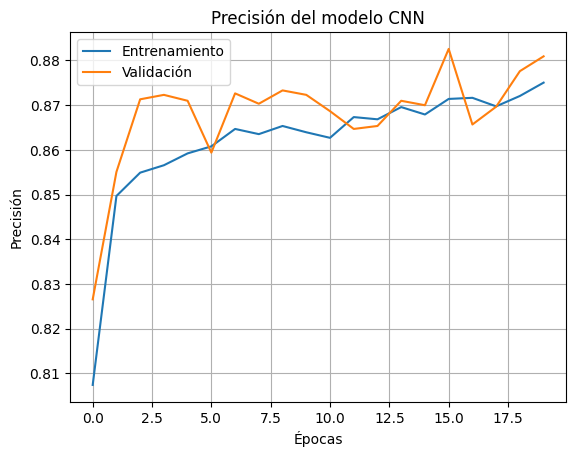

In [14]:
# Predicciones
y_pred_probs = model.predict(X_test_d)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)

# Reporte de clasificación
print("Evaluación del modelo CNN:")
print(classification_report(y_true_labels, y_pred_labels))

# Visualizar precisión durante el entrenamiento
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo CNN')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
last_conv_layer_name = "last_conv"

cam_model = Model(
    inputs=model.input,
    outputs=[
        model.get_layer(last_conv_layer_name).output,
        model.output
    ]
)

In [16]:
def mostrar_CAM(img_array, true_label, model, cam_model, class_names=["No Cancer", "Cancer"]):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np
    import cv2

    conv_output, predictions = cam_model.predict(np.expand_dims(img_array, axis=0))
    pred_class = np.argmax(predictions[0])
    confidence = predictions[0][pred_class]

    # Pesos de la capa final (output)
    weights = model.get_layer("output").get_weights()[0]  # shape: (128, 2)

    # CAM: dot product del conv_output con los pesos
    conv_flat = conv_output[0].reshape((-1, conv_output.shape[-1]))  # (81, 128)
    cam = np.dot(conv_flat, weights[:, pred_class])  # (81,)
    cam = cam.reshape((conv_output.shape[1], conv_output.shape[2]))  # (9, 9)

    # Normalizar y redimensionar
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = cv2.resize(cam, (50, 50))
    heatmap = cm.jet(cam)[:, :, :3]
    superimposed = heatmap * 0.5 + img_array
    superimposed = np.clip(superimposed, 0, 1)

    # Mostrar resultados
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title(f"Original ({class_names[true_label]})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title(f"CAM: {class_names[pred_class]} ({confidence:.2f})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


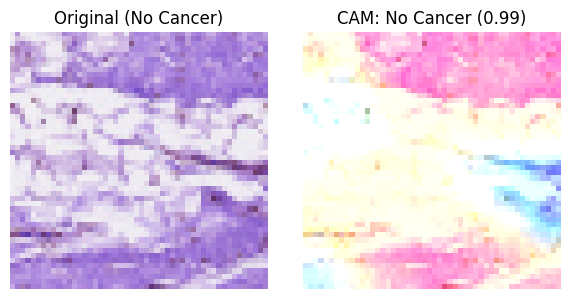

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


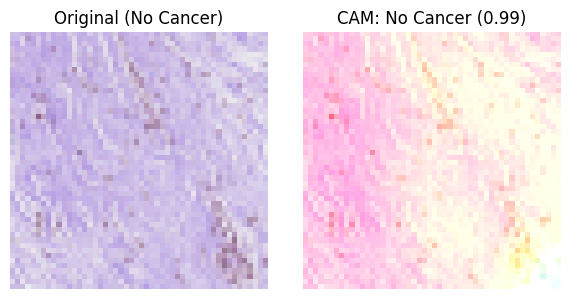

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


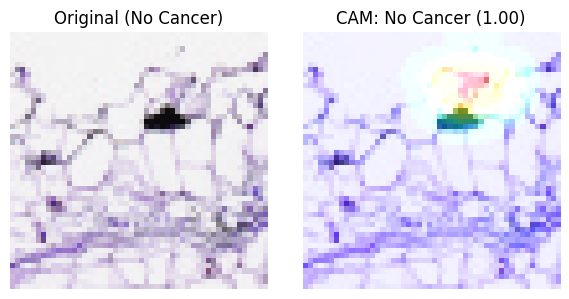

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


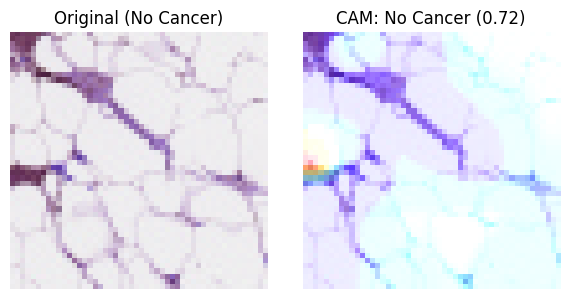

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


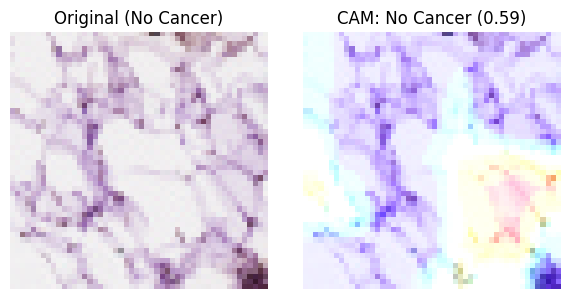

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


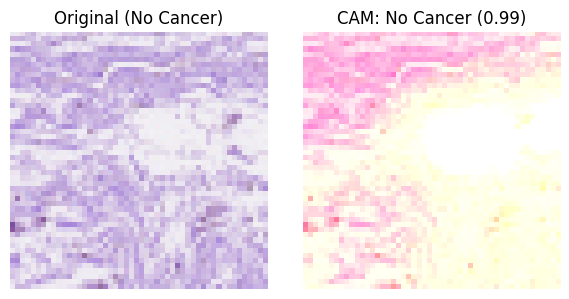

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


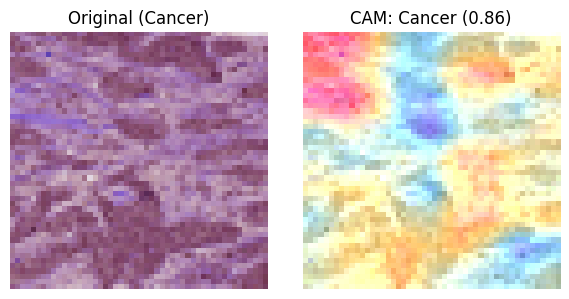

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


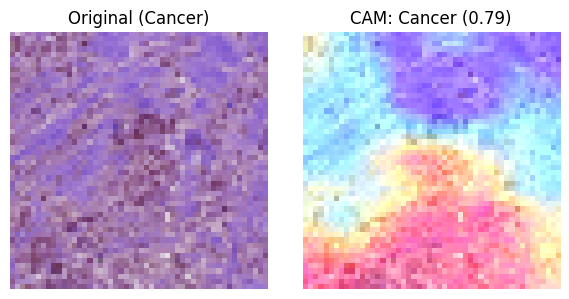

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


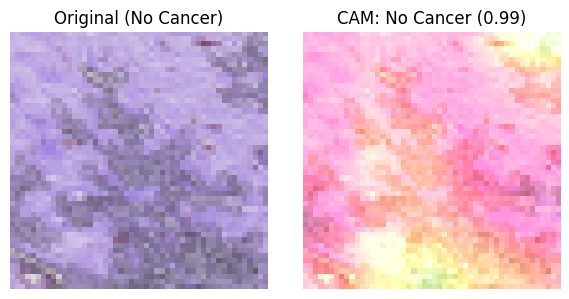

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


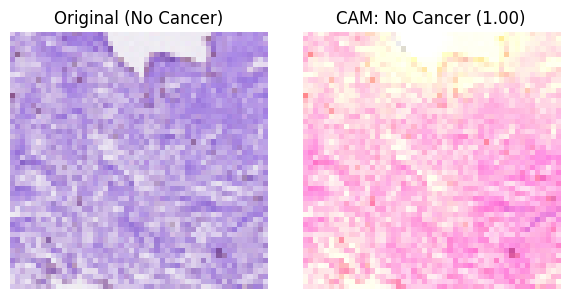

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


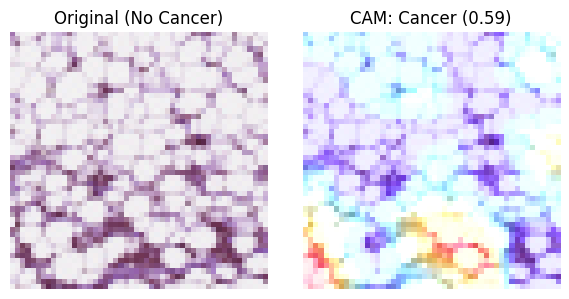

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


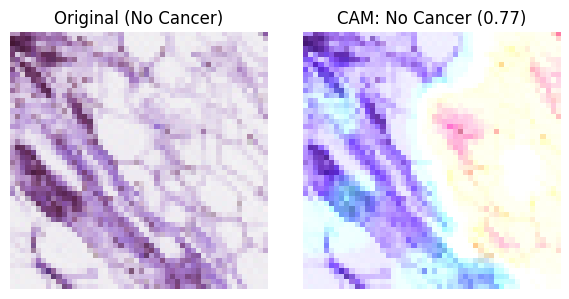

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


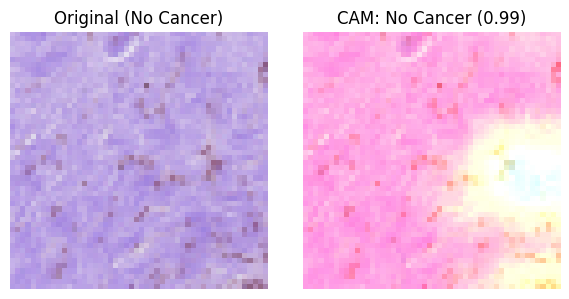

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


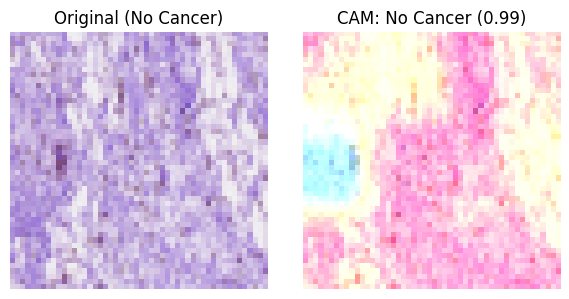

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


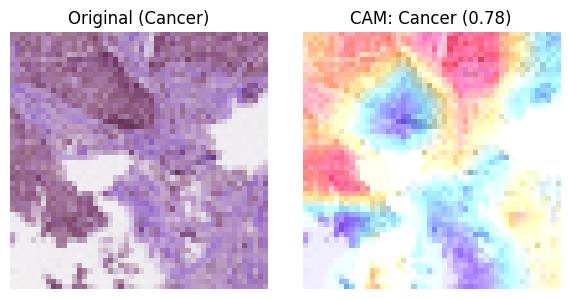

In [18]:
for i in range(15):
    idx = np.random.randint(len(X_test_d))
    mostrar_CAM(X_test_d[idx], y_test_d[idx], model, cam_model)
